In [1]:
from pdf_annotation import App
# app = App(f"../pdfs", bulk_render=False)
# app

In [2]:
# for node in app.tree_visualizer.root.dfs():
    # do something with the node
    # node._path (path to pdf file)
    # node._type (one of: "pdf", "folder", "text", "section", or "image")
    # node.content (list of dicts for every box drawn with this node selected)
        # {
        #     "value":
        #     "page":
        #     "coords":
        # }
    # print(node.label, node._type)

In [3]:
from ipywidgets import HTML
# HTML(app.tree_visualizer.selected_nodes[0].to_html())

In [4]:
# from pdf_annotation.utils.table_extraction import img_2_table

In [7]:
import PIL.Image as pil
import pytesseract as tess
import pandas as pd
import numpy as np
import cv2

In [353]:

def img_2_table(img):
    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(
        src=imgray, 
        thresh=180, 
        maxval=255, 
        type=cv2.THRESH_BINARY_INV
    )
    
    kernel = np.ones((5,5),np.uint8)
    dilated_value = cv2.dilate(thresh, kernel, iterations = 1)
    
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    items = []
    for contour, hierarchy in zip(contours, hierarchy[0]):
        # n, p, f, p = hierarchy
        # if p == 0: # immediate child of the largest box
        x, y, w, h = cv2.boundingRect(contour)
        if w>20 and h>20:
            text = tess.image_to_string(pil.fromarray(img).crop((x,y,x+w,y+h)), config="--psm 1").strip()
            # print(text)
            items.append((x,y,text))
            img = cv2.rectangle(
                img=img, 
                pt1=(x, y), 
                pt2=(x + w, y + h), 
                color=(0, 0, 255), 
                thickness=1
            )
    items.sort(key = lambda x: (x[1],x[0]))
    rows = [[items[0]]]
    for i in items[1:]:
        if i[0] < rows[-1][-1][0]:
            rows.append([i])
        else:
            rows[-1].append(i)
    rows = [[i[2] for i in r] for r in rows]
    print(rows)
        
    return img

[['FORCE HEADQUARTERS GROUP\n4h Intelligence Support Batalon\n\n“4h Air and Naval Gunfire Lisison Company\n3d Air and Naval Gunfire Liston Company\n(6h Air and Naval Gunfire Lisison Company\nIst Civil Affi Group\n\n2d Civil Aire Group\n3d Civil Aire Group\n“4h Chil Airs Group\n“4h Law Enforcement Batalion\n(6h Commauniations Battalion\n\n4TH MARINE DIVISION\nDivision Headquarters\n\n23d Marine Regiment\n\nIst Battalion\n\n2a Battalion\n\n3 Battalion\n\n2nd Battalion, 4th Marines\n\n25th Marine Regiment\nIstBatalion\n2a Battalion\n3 Battalion\n1st Battalion, 4th Marines\n\n14th Marine Regiment\n24 Battalion GHIMARS)\n3 Battalion\n5th Battalion\n4th Tank Bataion\n4h Assault Amphibious Battalion\n4h Light Ammored Reconnaissance Battalion\n‘4th Combat Engineer Battalion\n4th Recommissance Bataion\n$34 Force Reconnaissance Company\n4th Foree Reconnaissance Company\n\n4TH MARINE AIRCRAFT WING\nHeadquarters 4th Marine Airerah Wing\nDet VMR Andrews AFB\n\nDet VMR IRB Bille Chasse\n\nNEW ORLEAN

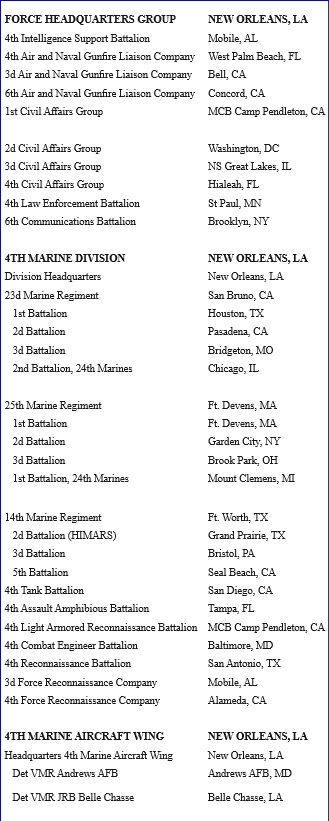

In [355]:
img = cv2.imread("../Capture4.png")
pil.fromarray(img_2_table(img))

In [356]:
def image_to_data(img):
    lines = tess.image_to_data(img,config="--psm 3").split("\n")
    columns = lines[0].split("\t")
    data = [line.split("\t") for line in lines[1:-1]]
    data = [[float(x) for x in row[:-1]] + [row[-1]] for row in data if row[-2] != "-1" and row[-1].strip()]
    return pd.DataFrame(data, columns = columns)

In [357]:
from pdf_annotation.widgets.dataframe_widget import DataFrame

In [374]:
data = image_to_data(img)
# data.drop(columns=["level","page_num","block_num","line_num","word_num","par_num","conf"], inplace=True)
data["right"] = data["left"] + data["width"]
data["bottom"] = data["top"] + data["height"]
data["cx"] = (data["left"] + data["right"] ) / 2
data["cy"] = (data["top"] + data["bottom"] ) / 2
DataFrame(data)

DataFrame(children=(_Header(children=(_ButtonCell(layout=Layout(width='4%'), style=ButtonStyle(), _dom_classes…

In [359]:
import matplotlib.pyplot as plt

In [360]:
from sklearn.cluster import DBSCAN

In [361]:
from collections import defaultdict

def cost(pred):
    bins = defaultdict(int)
    for p in pred: bins[p] += 1
    std = np.array(list(bins.values())).std()
    if len(bins)==1: return 1000
    return len(bins)/len(pred) + std

In [366]:
def score(data, eps):
    model = DBSCAN(eps=eps,min_samples=1)
    return cost(model.fit_predict(data))

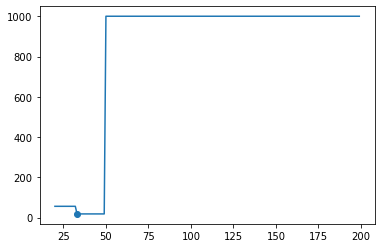

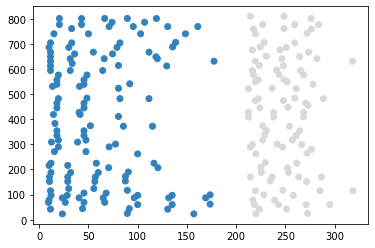

In [367]:
d_slice = data[["cx","cx"]]
x = range(20,200,1)
y = [score(d_slice,eps) for eps in x]
best_fit = x[np.array(y).argmin()]

color = DBSCAN(eps=best_fit,min_samples=1).fit_predict(d_slice)

plt.plot(x,y)
plt.scatter(best_fit,min(y))
plt.show()
plt.scatter(data["cx"],data["bottom"],c=color,cmap="tab20c")

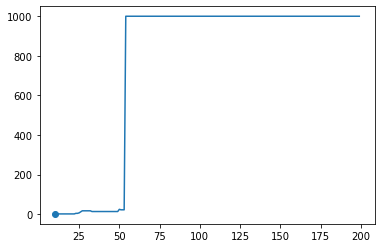

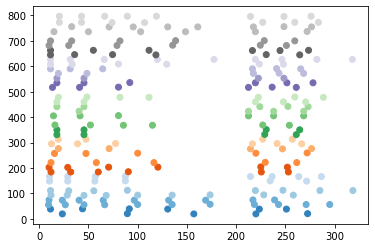

In [373]:
d_slice = data[["cy","cy"]]
x = range(10,200,1)
y = [score(d_slice,eps) for eps in x]
best_fit = x[np.array(y).argmin()]

color = DBSCAN(eps=best_fit,min_samples=1).fit_predict(d_slice)

plt.plot(x,y)
plt.scatter(best_fit,min(y))
plt.show()
plt.scatter(data["cx"],data["cy"],c=color,cmap="tab20c")